# Shallow Water SOMA Test Case Experiment

In [116]:
import sys
sys.path.append("../")
from mfmc import *

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(8)  #for reproducibility

from scipy.io import loadmat
mat = loadmat('data/SWEfilesNEW')['mat']
costs = loadmat('data/comp_costs_SOMA.mat')['times']

from scipy.interpolate import interp1d

### Load and preprocess data, select models

In [117]:
N = 100  #number of samples for corr/var estimation
nrRuns = 1
X = np.zeros((N,4,nrRuns))
for j in range(nrRuns):
    perm = rng.permutation(range(200))
    X[:,0,j] = mat[perm[:N],0]
    X[:,1,j] = mat[perm[:N],1]
    X[:,2,j] = mat[perm[:N],2]
    x = [-0.5,0,0.5]
    f = np.zeros(3)
    for i in range(3):
        name32 = loadmat(f'data/32km_interp{i+1}')
        f[i] = name32['hmax']
    cList = mat[perm[:N],3]
    interpolant = interp1d(x, f, 'linear')
    X[:,3,j] = interpolant(cList)
X = np.mean(X, axis=2)

print(np.corrcoef(X.T))

# w = np.array([1187, 140, 13, 0.33])
w = np.append(np.mean(costs, axis=0), 0.05)
print(w)
iset = np.array([0, 1, 2, -1])

# generate optimal ordering of models
[bestSet, bestV, vMC] = optimalOrderCorr(X, w, w[0]*2**6, 1)
bestSet=np.array([0, 2, 3])  #hard coded -- we disallow the case [0,3] only
w = w[bestSet]
X = X[:, bestSet]
iset = iset[bestSet]
print(f'selected models {bestSet}')

[[1.         0.99975045 0.9997592  0.99974835]
 [0.99975045 1.         0.99999933 0.99999759]
 [0.9997592  0.99999933 1.         0.99999822]
 [0.99974835 0.99999759 0.99999822 1.        ]]
[1.01122671e+02 1.28349744e+01 1.71439314e+00 5.00000000e-02]
[0] has variance 6.548389385085142e-06
[0 1] has variance 9.38212494520254e-07
[0 2] has variance 1.5153062421475956e-07
[0 3] has variance 1.306294897450525e-08
[0 2 1] has variance 9.389542702989943e-07
[0 1 3] is not feasible
[0 2 3] has variance 1.3131853094329994e-08
[0 2 1 3] is not feasible
selected models [0 2 3]


In [118]:
nrRuns = 250  #average of nrRuns runs
pList = w[0]*np.array([2**k for k in range(1,8)])

# Modified MFMC

# estimate mean of output
yMean = np.zeros((len(pList), nrRuns))
costs = np.zeros(len(pList))
for run in range(nrRuns):
#     print(f'run {run+1} of {nrRuns}')
    for (j,p) in enumerate(pList):  #compute estimate for different budgets
        # compute optimal number of model evals/coefficients
        Mlevel, coeff, v = optiMlevelCorr(X, w, p, 1)
        if run==0: print(f'Number of model evals is {Mlevel}')

        # FO model
        perm = rng.permutation(range(200))
        y = mat[perm[:Mlevel[0]], 0]
        yMeanCur = coeff[0] * np.mean(y)
        costs[j] = Mlevel[0] * w[0]
    
        # iterate over all other models
        idx = np.array([0,200,500,500])
        for i in range(1, len(w)):      # this assumes model 4 is in the set
            if iset[i] > 0:
                permNew = np.zeros(idx[i+1])
                permNew[:idx[i]] = perm
                pRest = idx[i] + rng.permutation(range(idx[i+1] - idx[i]))
                permNew[idx[i]:idx[i+1]] = pRest
                permNew = permNew.astype(int)
#                 print(permNew)
                y = mat[permNew[:Mlevel[i]], iset[i]]
                yMeanCur += coeff[i] * (np.mean(y) - np.mean(y[:Mlevel[i-1]]))
                costs[j] += Mlevel[i] * w[i]
                perm = permNew
            else:
#                 print(i)
                samps = -0.5 + rng.random(Mlevel[i])
                samps[:Mlevel[i-1]] = mat[perm[:Mlevel[i-1]],3]
                y = interpolant(samps)
                yMeanCur += coeff[i] * (np.mean(y) - np.mean(y[:Mlevel[i-1]]))
                costs[j] += Mlevel[i] * w[i]

        yMean[j, run] = yMeanCur
        
        
# Simple MC
        
yMeanFOM = np.zeros((len(pList), nrRuns))
costsFOM = np.zeros(len(pList))
for run in range(nrRuns):
    perm = rng.permutation(rng.permutation(range(200)))  #trick to get new permutation with same seed
    for (j,p) in enumerate(pList):
        M = np.ceil(p / w[0]).astype(int)  #number of samples
        y = mat[perm[:M], 0]
        yMeanFOM[j, run] = np.mean(y)
        costsFOM[j] = M * w[0]

Number of model evals is [   1    1 1968]
Number of model evals is [   1    3 4016]
Number of model evals is [   3    6 8032]
Number of model evals is [    7    12 16064]
Number of model evals is [   15    25 32128]
Number of model evals is [   31    51 64256]
Number of model evals is [    62    102 128512]


### Compute metrics for evaluation and plot results

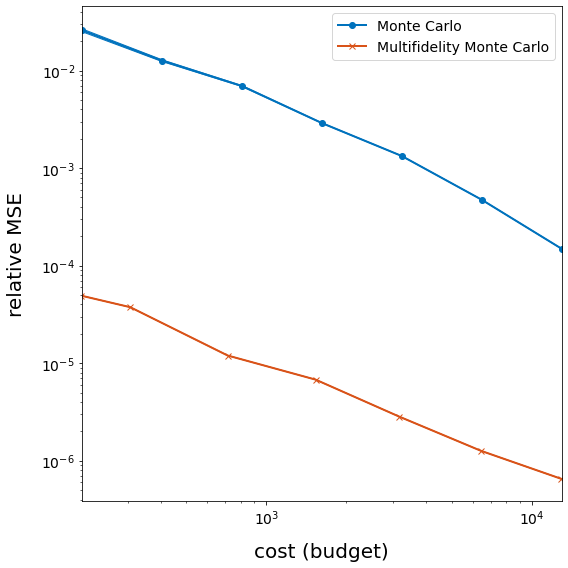

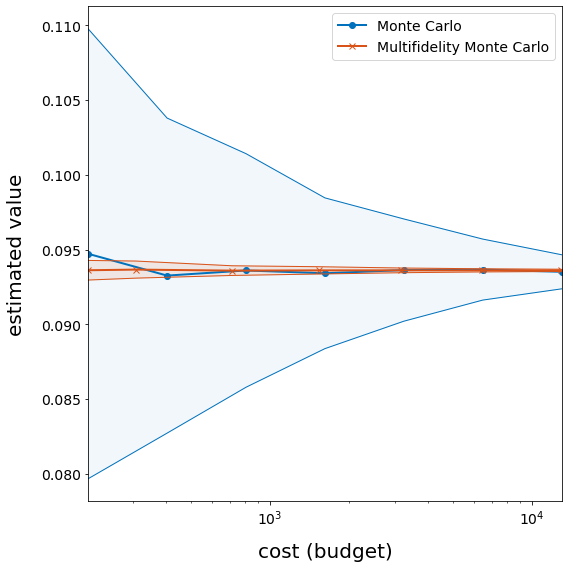

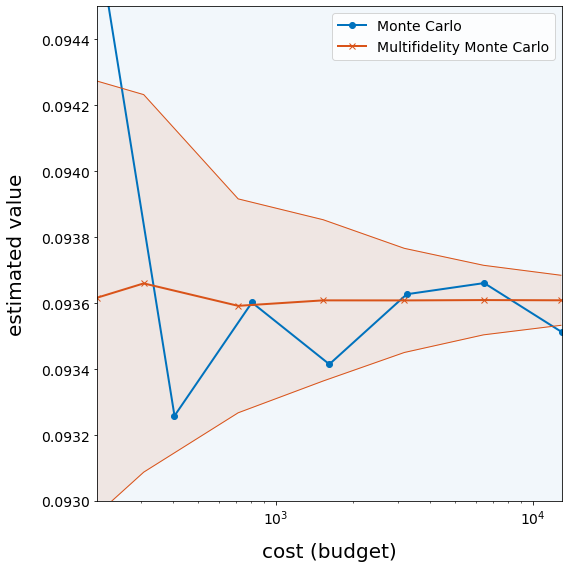

In [120]:
myMeanFOM = np.mean(yMeanFOM, axis=1)
myMean = np.mean(yMean, axis=1)

yMeanStdFOM = np.std(yMeanFOM, axis=1, ddof=1)
yMeanStd = np.std(yMean, axis=1, ddof=1)

# estimate reference mean (USING MFMC!)
yMeanRef = np.mean(yMean[-1])
# yMeanRef = mean(yMeanFOM(end,:));

# estimate MSE
mseMFMC = np.zeros(len(pList))
mseMC = np.zeros(len(pList))
abseMFMC = np.zeros(len(pList))
abseMC = np.zeros(len(pList))
for j in range(len(pList)):
    mseMFMC[j] = np.mean((yMeanRef - yMean[j])**2)
    abseMFMC[j] = np.mean(np.abs(yMeanRef - yMean[j]))
    mseMC[j] = np.mean((yMeanRef - yMeanFOM[j])**2)
    abseMC[j] = np.mean(np.abs(yMeanRef - yMeanFOM[j]))

mseMC = np.mean((yMeanRef - yMeanFOM)**2, axis=1)
mseMFMC = np.mean((yMeanRef - yMean)**2, axis=1)

varmseMC = np.var((yMeanRef - yMeanFOM)**2 / yMeanRef**2, axis=1)
varmseMFMC = np.var((yMeanRef - yMean)**2 / yMeanRef**2, axis=1)

relmseMC = mseMC / yMeanRef**2
relmseMFMC = mseMFMC / yMeanRef**2

# Plotting
c1 = [0, 0.4470, 0.7410];
c2 = [0.8500, 0.3250, 0.0980];
c4 = [0.4940, 0.1840, 0.5560];
c3 = [0.4660, 0.6740, 0.1880];

fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('cost (budget)', labelpad=15)
ax.set_ylabel('relative MSE', labelpad=15)
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_xlim([pList[0],pList[-1]])
ax.plot(costsFOM, relmseMC, '-o', color=c1, linewidth=2, label='Monte Carlo')
ax.plot(costs, relmseMFMC, '-x', color=c2, linewidth=2, label='Multifidelity Monte Carlo')
x=costsFOM
curve1 = relmseMC + varmseMC
curve2 = relmseMC - varmseMC
ax.plot(x, curve1, color=c1, linewidth=1)
ax.plot(x, curve2, color=c1, linewidth=1)
x2 = np.concatenate([x, x[::-1]], axis=0)
inBetween = np.concatenate([curve1, curve2[::-1]], axis=0)
ax.fill(x2, inBetween, color=c1, alpha=0.05)
x=costs
curve1 = relmseMFMC + varmseMFMC
curve2 = relmseMFMC - varmseMFMC
ax.plot(x, curve1, color=c2, linewidth=1)
ax.plot(x, curve2, color=c2, linewidth=1)
x2 = np.concatenate([x, x[::-1]], axis=0)
inBetween = np.concatenate([curve1, curve2[::-1]], axis=0)
ax.fill(x2, inBetween, color=c2, alpha=0.1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={'size': 14})
plt.tight_layout()
# plt.savefig('soma_mses.png', transparent=True)
plt.show()

fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.tick_params(labelsize=14)
ax.set_xlabel('cost (budget)', labelpad=15)
ax.set_ylabel('estimated value', labelpad=15)
ax.set_xscale('log', base=10)
ax.set_xlim([pList[0], pList[-1]])
ax.plot(costsFOM, myMeanFOM, '-o', color=c1, linewidth=2, label='Monte Carlo')
ax.plot(costs, myMean, '-x', color=c2, linewidth=2, label='Multifidelity Monte Carlo')
x=costsFOM
curve1 = myMeanFOM + yMeanStdFOM
curve2 = myMeanFOM - yMeanStdFOM
ax.plot(x, curve1, color=c1, linewidth=1)
ax.plot(x, curve2, color=c1, linewidth=1)
x2 = np.concatenate((x, x[::-1]), axis=0)
inBetween = np.concatenate((curve1, curve2[::-1]), axis=0)
ax.fill(x2, inBetween, color=c1, alpha=0.05)
x=costs
curve1 = myMean + yMeanStd
curve2 = myMean - yMeanStd
ax.plot(x, curve1, color=c2, linewidth=1)
ax.plot(x, curve2, color=c2, linewidth=1)
x2 = np.concatenate([x, x[::-1]], axis=0)
inBetween = np.concatenate([curve1, curve2[::-1]], axis=0)
ax.fill(x2, inBetween, color=c2, alpha=0.1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={'size': 14})
plt.tight_layout()
# plt.savefig('soma_values.png', transparent=True)
plt.show()

fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.tick_params(labelsize=14)
ax.set_xlabel('cost (budget)', labelpad=15)
ax.set_ylabel('estimated value', labelpad=15)
ax.set_xscale('log', base=10)
ax.set_xlim([pList[0], pList[-1]])
ax.set_ylim([0.093, 0.0945])
ax.plot(costsFOM, myMeanFOM, '-o', color=c1, linewidth=2, label='Monte Carlo')
ax.plot(costs, myMean, '-x', color=c2, linewidth=2, label='Multifidelity Monte Carlo')
x=costsFOM
curve1 = myMeanFOM + yMeanStdFOM
curve2 = myMeanFOM - yMeanStdFOM
ax.plot(x, curve1, color=c1, linewidth=1)
ax.plot(x, curve2, color=c1, linewidth=1)
x2 = np.concatenate((x, x[::-1]), axis=0)
inBetween = np.concatenate((curve1, curve2[::-1]), axis=0)
ax.fill(x2, inBetween, color=c1, alpha=0.05)
x=costs
curve1 = myMean + yMeanStd
curve2 = myMean - yMeanStd
ax.plot(x, curve1, color=c2, linewidth=1)
ax.plot(x, curve2, color=c2, linewidth=1)
x2 = np.concatenate([x, x[::-1]], axis=0)
inBetween = np.concatenate([curve1, curve2[::-1]], axis=0)
ax.fill(x2, inBetween, color=c2, alpha=0.1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={'size': 14})
plt.tight_layout()
# plt.savefig('soma_values_close.png', transparent=True)
plt.show()